In [1]:
%load_ext autoreload
%autoreload 2 


In [25]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
import os
import torchvision

# Configuraciones

Configuraciones para CUDA

In [4]:
# Configuraciones para CUDA
os.environ["CUDA_LAUNCH_BLOCKING"]="1"

In [5]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device a utilizar:",device)

Device a utilizar: cpu


# Analisis de datos

In [74]:
from datasets import MPIIFaceGaze

In [75]:
ds = MPIIFaceGaze("./datasets/MPIIFaceGaze.h5", imgs_per_individual=10)
print(f"Se cargaron {len(ds)} imagenes")

Dataset cargado correctamente de C:\Users\DELL\Documents\LSE\vpcII\tp\vpc2_project\datasets\MPIIFaceGaze.h5
Se cargaron 150 imagenes


In [76]:
ds[20]

(array([[[17, 29, 42],
         [18, 30, 45],
         [19, 31, 46],
         ...,
         [26, 20, 13],
         [23, 22, 14],
         [23, 23, 15]],
 
        [[18, 30, 42],
         [18, 31, 45],
         [19, 32, 46],
         ...,
         [26, 19, 12],
         [25, 20, 14],
         [25, 22, 15]],
 
        [[17, 31, 43],
         [18, 33, 46],
         [18, 33, 46],
         ...,
         [26, 18, 12],
         [25, 19, 13],
         [26, 21, 15]],
 
        ...,
 
        [[27, 34, 42],
         [24, 31, 39],
         [21, 28, 34],
         ...,
         [55, 50, 58],
         [52, 47, 55],
         [48, 41, 48]],
 
        [[27, 35, 42],
         [24, 32, 38],
         [22, 29, 34],
         ...,
         [57, 49, 57],
         [53, 46, 54],
         [51, 41, 46]],
 
        [[26, 36, 42],
         [23, 33, 38],
         [21, 30, 34],
         ...,
         [58, 48, 55],
         [55, 45, 51],
         [52, 40, 45]]], dtype=uint8),
 array([-0.01167867,  0.0348981 ]))

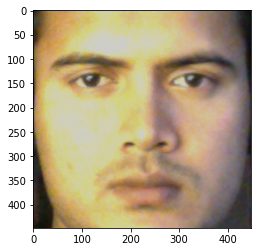

In [77]:
plt.imshow(ds.images_list[20][:,:,::-1])

# Entrenamiento

Instanciación del modelo y prueba de dimensiones

In [168]:
from models import GazeEstimation_ResNet18
from torchsummary import summary

In [169]:
# Instanciación del model
model = GazeEstimation_ResNet18(pretrained=True)

# Al ser un problema de regresión se usa MSELoss
criterion = nn.MSELoss()

# Optimizador: Adam
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Example forward pass with random input
inputs = torch.randn(8, 3, 224, 224)  # Batch of 8 images, 3 channels (RGB), 224x224 resolution
outputs = model(inputs)  # Outputs will be the predicted yaw and pitch angles

print(outputs)


tensor([[ 0.2780,  0.0283],
        [ 0.1109,  0.0847],
        [ 0.2639,  0.0225],
        [ 0.0998,  0.3976],
        [ 0.2006, -0.0763],
        [-0.0762,  0.0749],
        [ 0.0937, -0.0331],
        [ 0.0528,  0.0781]], grad_fn=<AddmmBackward0>)


In [163]:
summary(model.to(device), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

#### Creación de los set de entrenamiento y testeo

In [150]:
WIDTH = 224
HIGH = 224

data_transforms = transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((WIDTH, HIGH))
])


In [155]:
ds = MPIIFaceGaze("./datasets/MPIIFaceGaze.h5", transform=data_transforms, imgs_per_individual=5)
print(f"Se cargaron {len(ds)} imagenes")

Dataset cargado correctamente de C:\Users\DELL\Documents\LSE\vpcII\tp\vpc2_project\datasets\MPIIFaceGaze.h5
Se cargaron 75 imagenes


In [156]:
# Separo en entrenamiento y validacion
train_size = int(0.8*len(ds))  
test_size = len(ds)-train_size

train_dataset, test_dataset = random_split(ds, [train_size, test_size])

# Creo los dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)


torch.Size([16, 3, 224, 224]) torch.Size([16, 2])
pitch yaw: tensor([-0.3605,  0.0675], dtype=torch.float64)


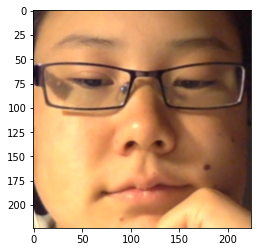

In [157]:
train_image, train_labels = next(iter(train_loader))

print(train_image.shape, train_labels.shape)

# Grafico una imagen con el label para asegurarnos que este bien cargada 
plt.imshow(train_image[0].permute(1, 2, 0).numpy()[:,:,::-1])
print(f'pitch yaw: {train_labels[0]}')

#### Entrenamiento propiamente dicho

In [170]:
model.fit(train_loader, val_loader, criterion, optimizer, epochs=10, device=device, save_model='gaze_estimation_resnet18.pth')

Epoch 1/10


Validation loss 1.63978: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


Training Loss: 0.9898 | Validation Loss: 1.6398
Epoch 2/10


Validation loss 0.18585: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]


Training Loss: 0.4112 | Validation Loss: 0.1859
Epoch 3/10


Validation loss 0.66822: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Training Loss: 0.0537 | Validation Loss: 0.6682
Epoch 4/10


Validation loss 0.27987: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


Training Loss: 0.0267 | Validation Loss: 0.2799
Epoch 5/10


Validation loss 0.15639: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Training Loss: 0.0167 | Validation Loss: 0.1564
Epoch 6/10


Validation loss 0.08230: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


Training Loss: 0.0160 | Validation Loss: 0.0823
Epoch 7/10


Validation loss 0.04899: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


Training Loss: 0.0124 | Validation Loss: 0.0490
Epoch 8/10


Validation loss 0.03153: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.41it/s]


Training Loss: 0.0109 | Validation Loss: 0.0315
Epoch 9/10


Validation loss 0.02360: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.42it/s]


Training Loss: 0.0072 | Validation Loss: 0.0236
Epoch 10/10


Validation loss 0.02817: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]

Training Loss: 0.0068 | Validation Loss: 0.0282


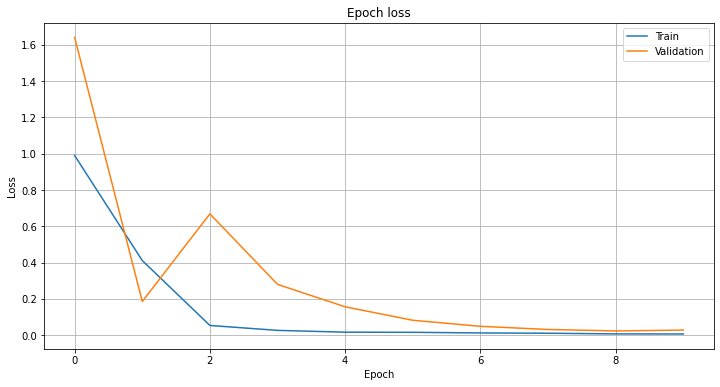

In [171]:
# Grafico las curvas de entrenamiento y validacion
plt.figure(figsize=(12, 6))
plt.title("Epoch loss")
plt.plot(range(0,len(model.epoch_train_loss)), model.epoch_train_loss, label='Train')
plt.plot(range(0,len(model.epoch_train_loss)), model.epoch_val_loss, label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()  
plt.legend()    

In [175]:
# Para probar que se haya guardado bien el mejor modelo entrenado
new_model = GazeEstimation_ResNet18()
new_model.load_state_dict(torch.load('gaze_estimation_resnet18.pth'))

inputs = torch.randn(8, 3, 224, 224)  # Batch of 8 images, 3 channels (RGB), 224x224 resolution
outputs = new_model(inputs)  # Outputs will be the predicted yaw and pitch angles

print(outputs)

tensor([[-0.2571, -0.0535],
        [-0.2075, -0.2024],
        [-0.1624, -0.0270],
        [-0.1834,  0.1339],
        [-0.1968, -0.0025],
        [-0.2179,  0.1394],
        [-0.2086,  0.1329],
        [-0.1901,  0.1065]], grad_fn=<AddmmBackward0>)
